## Tutorial 1. Introduction to the revisit prediction

Written by Sundong Kim (sundong.kim@kaist.ac.kr), Nov 15th, 2018,

In this tutorial, we introduce how to play with indoor mobility datasets.

* First, we find some statistics of the dataset
* Second, we generate basic statistical features from each visit.
    * total dwell time
    * the number of area
    * the number of unique areas
* Third, we perform binary classification to predict customer revisit intention.

In [1]:
import pandas as pd
import numpy as np
import os
import random

# In this tutorial, we will use a store_A dataset.
pre_release_path = '../data/indoor/store_E/'

In [2]:
# Load dataset

train_labels = pd.read_csv(pre_release_path+'train_labels.tsv', sep='\t')
test_labels = pd.read_csv(pre_release_path+'test_labels.tsv', sep='\t')
train_visits = pd.read_csv(pre_release_path+'train_visits.tsv', sep='\t')
test_visits = pd.read_csv(pre_release_path+'test_visits.tsv', sep='\t')
wifi_sessions = pd.read_csv(pre_release_path+'wifi_sessions.tsv', sep='\t')

### 1. Exploring dataset

In [3]:
train_labels.head(5)

,visit_id,revisit_interval,revisit_intention
0,v0,0.89,1
1,v1,0.57,1
2,v2,0.61,1
3,v3,0.69,1
4,v4,0.57,1


In [4]:
train_visits.head(5)

,visit_id,wifi_id,date,indices
0,v0,101,17168,11944;12695;13050;13303;13588;13860;14068
1,v1,101,17169,18544;18795;19319;19542;19733;19866
2,v2,101,17170,20229;20504;20661;20992;21147;25101;25347;2584...
3,v3,101,17171,27060;27683;28120;28553;28890;29439;29832;3108...
4,v4,101,17172,33258;33518;34111;34679;34908;36467;38301;3872...


In [5]:
test_labels.head(5)

,visit_id,revisit_interval,revisit_intention
0,v221832,1.03,1
1,v221833,0.99,1
2,v221834,0.57,1
3,v221835,1.65,1
4,v221836,0.87,1


In [6]:
test_visits.head(5)

,visit_id,wifi_id,date,indices
0,v221832,101,17350,1237614
1,v221833,102,17348,1225636;1225812
2,v221834,107,17348,1225976;1227244;1230997;1231972;1234579
3,v221835,118,17348,1226654;1227647;1227891;1230057;1231145;123331...
4,v221836,121,17351,1246948;1248655


In [7]:
wifi_sessions.head(5)

,index,wifi_id,ts,area,dwell_time
0,0,134,1483217954,max,3056
1,1,134,1483218037,out,648
2,2,347,1483218115,max,125
3,3,134,1483219601,out,179
4,4,134,1483220608,out,381


**Some statistics**

In [8]:
# Number of unique users

print(len(train_labels),len(train_visits),len(test_labels),len(test_visits),len(wifi_sessions))

221832 221832 32351 32351 1507166


In [9]:
# Number of unique users

len(set(train_visits.wifi_id)), len(set(test_visits.wifi_id)) 

(39737, 32351)

In [10]:
# Revisit ratio

print(train_labels.revisit_intention.value_counts())
print()
print(test_labels.revisit_intention.value_counts())

1    204183
0     17649
Name: revisit_intention, dtype: int64

1    20237
0    12114
Name: revisit_intention, dtype: int64


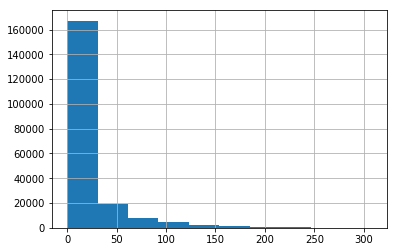

In [11]:
# Revisit interval - train data - among users who revisit
%matplotlib inline
train_labels.revisit_interval.hist()

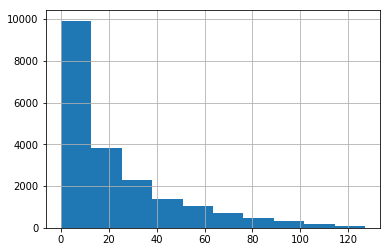

In [12]:
# Revisit interval - test data - among users who revisit
test_labels.revisit_interval.hist()

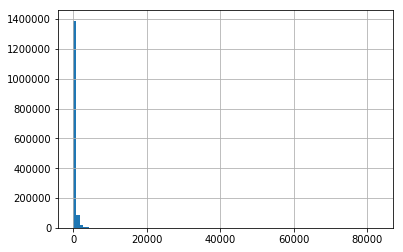

In [13]:
# Wifi session logs distribution by dwell_time
wifi_sessions.dwell_time.hist(bins=100)

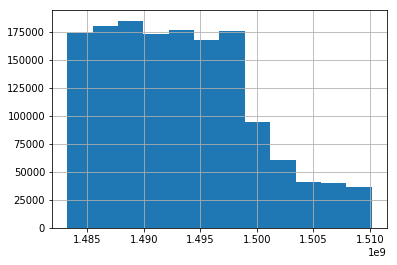

In [14]:
# Wifi session logs distribution by each month:
#  - The number of logs from train period is larger than the number of logs from test period.
#  - Since we only retain one indoor visit for each wifi-id in the test period.
wifi_sessions.ts.hist(bins=12)

In [15]:
# Wifi session logs distribution by area
wifi_sessions.area.value_counts()

max             372335
out             229430
in               91472
center           60660
sensor19         48441
sensor5          48346
jk3              43448
sensor7          41989
indi-brand       33903
bcd              33832
sensor15         33625
indi-brand2      33230
ghi              31373
sensor10         29252
ef               28156
out2             27000
sensor14         26079
sensor17         25951
sensor16         25408
jk2              24142
sensor4          21798
jk               20901
out1             19786
sensor9          19708
sensor18         14675
sensor8          13948
sensor2          13847
sensor6          13568
sensor3          10716
ent2              8709
sensor1           8346
sensor12          7893
ent               7637
sensor11          7221
fitting-room      6376
sensor13          5721
counter           5132
fitting1          4483
k-fashion         3138
fitting2          3094
sensor20          2397
Name: area, dtype: int64

### 2. Feature generation

In [16]:
### Before feature engineering, querying some useful information from wifi-sessions data, and add to the dataframe.
import time
wifi_sessions = wifi_sessions.set_index('index')

def add_infos(df):  
    tst = time.time()
    df['l_index'] = df['indices'].apply(lambda x: [int(y) for y in x.split(';')])
    t1 = time.time()
    print(t1-tst)
    
    newidx = [item for sublist in list(df.l_index) for item in sublist]
    tmpdf = wifi_sessions.loc[newidx]
    traj_lens = df.l_index.apply(len)

    tmp_areas = list(tmpdf['area'])
    tmp_dt = list(tmpdf['dwell_time'])

    rslt_dt = []
    rslt_areas = []

    i = 0
    for x in traj_lens:
        rslt_dt.append(tmp_dt[i:i+x])
        rslt_areas.append(tmp_areas[i:i+x])
        i += x
        
    df['dwell_times'] = rslt_dt
    df['areas'] =  rslt_areas
    
    t2 = time.time()
    print(t2-t1)
    return df 

In [17]:
train_visits = add_infos(train_visits)
test_visits = add_infos(test_visits)

0.9716081619262695
3.422877550125122
0.12647414207458496
0.5389575958251953


In [18]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas
0,v0,101,17168,11944;12695;13050;13303;13588;13860;14068,"[11944, 12695, 13050, 13303, 13588, 13860, 14068]","[2333, 931, 591, 1532, 349, 142, 658]","[max, max, max, max, max, max, max]"
1,v1,101,17169,18544;18795;19319;19542;19733;19866,"[18544, 18795, 19319, 19542, 19733, 19866]","[61, 1118, 1068, 612, 6, 387]","[max, max, max, max, max, max]"
2,v2,101,17170,20229;20504;20661;20992;21147;25101;25347;2584...,"[20229, 20504, 20661, 20992, 21147, 25101, 253...","[452, 250, 751, 142, 18803, 355, 1676, 970, 89...","[max, max, max, max, max, max, max, max, max, ..."


In [19]:
### Sample code to generate features 

def statistical_feature_generator(x):
    fs = []

    total_dwell_time = sum(x['dwell_times'])   # total dwell time
    num_area_trajectory_have = len(x['dwell_times'])  # the number of area
    num_unique_area_sensed = len(set(x['areas']))  # the number of unique areas
    
    fs.append(total_dwell_time)
    fs.append(num_area_trajectory_have)  
    fs.append(num_unique_area_sensed)     
    
    return fs



def add_statistical_features(train_visits):
    df = train_visits.copy()
    
    features = df.apply(lambda x: statistical_feature_generator(x), axis=1)
    featureName = ['total_dwell_time', 'num_area', 'num_unique_area']
    
    fdf = pd.DataFrame(list(np.asarray(features)), index=features.index, columns = featureName)
    
    # Combine feature values to the dataframe
    df = pd.concat([df, fdf], axis=1)
    del fdf
    
    return df

In [20]:
train_visits = add_statistical_features(train_visits)
test_visits = add_statistical_features(test_visits)

In [21]:
train_visits.head(3)

,visit_id,wifi_id,date,indices,l_index,dwell_times,areas,total_dwell_time,num_area,num_unique_area
0,v0,101,17168,11944;12695;13050;13303;13588;13860;14068,"[11944, 12695, 13050, 13303, 13588, 13860, 14068]","[2333, 931, 591, 1532, 349, 142, 658]","[max, max, max, max, max, max, max]",6536,7,1
1,v1,101,17169,18544;18795;19319;19542;19733;19866,"[18544, 18795, 19319, 19542, 19733, 19866]","[61, 1118, 1068, 612, 6, 387]","[max, max, max, max, max, max]",3252,6,1
2,v2,101,17170,20229;20504;20661;20992;21147;25101;25347;2584...,"[20229, 20504, 20661, 20992, 21147, 25101, 253...","[452, 250, 751, 142, 18803, 355, 1676, 970, 89...","[max, max, max, max, max, max, max, max, max, ...",25247,10,1


### 3. Revisit Prediction (Binary classification)

In [22]:
### Retain only feature values

def remove_unnecessary_features(df):
    unnecessary_attributes = ['visit_id', 'wifi_id', 'date', 'indices', 'l_index', 'dwell_times', 'areas']
    all_attributes = list(df.columns)
    for attribute in unnecessary_attributes:
        try:
            all_attributes.remove(attribute)
        except:
            pass
    df = df[all_attributes]
    return df

df_train = remove_unnecessary_features(train_visits)
df_test = remove_unnecessary_features(test_visits)

In [23]:
import time
import xgboost as xgb
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def show_intention_classification_result(y_pred, y_test):
    return metrics.accuracy_score(y_test, y_pred)

def show_interval_regression_result(y_pred, y_test):
    return metrics.mean_squared_error(y_test, y_pred)

Downsampling for measuring binary classification accuracy

In [24]:
df_train = pd.concat([df_train, train_labels['revisit_intention']], axis=1)
df_test = pd.concat([df_test, test_labels['revisit_intention']], axis=1)

In [25]:
def label_balancing(df, name_target_column):
    ## 1:1 Downsampling
    minimum_label_num = list(df[name_target_column].value_counts())[-1]
    
    df_list = []
    for value in df[name_target_column].unique():
        sub_dfs = df.loc[df[name_target_column] == value]
        new_sub_dfs = sub_dfs.iloc[np.random.permutation(len(sub_dfs))][:minimum_label_num]  ## Random Downsampling according to smallest label size
        df_list.append(new_sub_dfs)
        del sub_dfs
        
    new_df = pd.concat(df_list).sort_index()
    
    return new_df

In [26]:
df_train.head(3)

,total_dwell_time,num_area,num_unique_area,revisit_intention
0,6536,7,1,1
1,3252,6,1,1
2,25247,10,1,1


In [27]:

acc = []

print('Class label distribution before downsampling - Train data: revisit_intention 0: {}, 1: {}'.format(
        df_train.revisit_intention.value_counts()[0],
        df_train.revisit_intention.value_counts()[1]))
print('Class label distribution before downsampling - Test data: revisit_intention 0: {}, 1: {}'.format(
        df_test.revisit_intention.value_counts()[0],
        df_test.revisit_intention.value_counts()[1]))
print()
print('-----------   Experiments Begin   -------------')
print()

for i in range(5):    
    
    ## Making downsampled dataset for measuring binary classification accuracy - baseline = 0.5
    whole_balanced_train = label_balancing(df_train, 'revisit_intention') 
    whole_balanced_test = label_balancing(df_test, 'revisit_intention') 
    print('Class label distribution after downsampling - Train data: revisit_intention 0: {}, 1: {}'.format(
        whole_balanced_train.revisit_intention.value_counts()[0],
        whole_balanced_train.revisit_intention.value_counts()[1]))
    print('Class label distribution after downsampling - Test data: revisit_intention 0: {}, 1: {}'.format(
        whole_balanced_test.revisit_intention.value_counts()[0],
        whole_balanced_test.revisit_intention.value_counts()[1]))
    
    
    for (train_data, test_data, ref) in [(whole_balanced_train, whole_balanced_test, 'Downsampled')]:
        train_array = np.asarray(train_data)  
        test_array = np.asarray(test_data)  

        # Dividing features and labels
        X_train, y_train = train_array[:, :-1], train_array[:, -1].astype(int)
        X_test, y_test = test_array[:, :-1], test_array[:, -1].astype(int)

        # Training
        start = time.time()
        clf = Pipeline([
          ('classification', XGBClassifier(max_depth=5, learning_rate=0.1))
        ])
        clf = clf.fit(X_train, y_train)

        # Prediction
        y_pred = clf.predict(X_test)
        clas_rslt = metrics.accuracy_score(y_test, y_pred)
        done = time.time()
        elapsed = done-start

        # Result
        print('Classification result', round(clas_rslt, 4))
#         print('Elapsed time:', round(elapsed, 4))
        print()
        acc.append(clas_rslt)
    
print()
print('-----------   Performance of our model   -------------')
print()
print('Average accuracy: {:.4f}'.format(np.mean(acc)))

Class label distribution before downsampling - Train data: revisit_intention 0: 17649, 1: 204183
Class label distribution before downsampling - Test data: revisit_intention 0: 12114, 1: 20237

-----------   Experiments Begin   -------------

Class label distribution after downsampling - Train data: revisit_intention 0: 17649, 1: 17649
Class label distribution after downsampling - Test data: revisit_intention 0: 12114, 1: 12114
Classification result 0.7082

Class label distribution after downsampling - Train data: revisit_intention 0: 17649, 1: 17649
Class label distribution after downsampling - Test data: revisit_intention 0: 12114, 1: 12114
Classification result 0.7089

Class label distribution after downsampling - Train data: revisit_intention 0: 17649, 1: 17649
Class label distribution after downsampling - Test data: revisit_intention 0: 12114, 1: 12114
Classification result 0.7112

Class label distribution after downsampling - Train data: revisit_intention 0: 17649, 1: 17649
Class 

In [35]:
### store A-E performance assessment

!python T1-Introduction-to-the-revisit-prediction.py A


-----------  Performance of our model (5-time averaged) (A)  -------------

Average accuracy: 0.6829


In [36]:
!python T1-Introduction-to-the-revisit-prediction.py B


-----------  Performance of our model (5-time averaged) (B)  -------------

Average accuracy: 0.6658


In [37]:
!python T1-Introduction-to-the-revisit-prediction.py C


-----------  Performance of our model (5-time averaged) (C)  -------------

Average accuracy: 0.6082


In [38]:
!python T1-Introduction-to-the-revisit-prediction.py D


-----------  Performance of our model (5-time averaged) (D)  -------------

Average accuracy: 0.7257


In [39]:
!python T1-Introduction-to-the-revisit-prediction.py E


-----------  Performance of our model (5-time averaged) (E)  -------------

Average accuracy: 0.7103
